# 04 - FFRD Frequency Analysis Based on RAS HDF Output Files

In [1]:
import ras_hdf_utils

import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import xarray as xr
import zarr

import glob
import os

In [2]:
from dask.distributed import Client

client = Client()
client

/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45217 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45217/status,
Dashboard: http://127.0.0.1:45217/status,Workers: 4
Total threads: 12,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40239,Workers: 4
Dashboard: http://127.0.0.1:45217/status,Total threads: 12
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:45351,Total threads: 3
Dashboard: http://127.0.0.1:40833/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:44487,


In [3]:
RAS_HDFS_DIR = './data/hdfs/'
PARQUET_DIR = './data/parquet/'
RAS_CELL_CENTER_ZARR = './data/ras_cell_center.zarr'
RAS_CELL_CENTER_ZARR_RECHUNKED = './data/ras_cell_center_rechunked.zarr'

## Extract data from HDF files
1. Cell center x,y coordinates
2. Maximum water surface elevation

In [4]:
# Convert cell center outputs to parquet files

if not os.path.exists(PARQUET_DIR):
    os.makedirs(PARQUET_DIR)

hdf_files = tqdm(glob.glob(f'{RAS_HDFS_DIR}/*.hdf'))
for hdf_file in hdf_files:
    hdf_file_name = os.path.basename(hdf_file)
    gdf = ras_hdf_utils.ras_hdf_2dpoints_to_geodataframe(hdf_file)
    gdf.to_parquet(os.path.join(PARQUET_DIR, f'{hdf_file_name}.center.parquet'))

100%|██████████| 96/96 [00:25<00:00,  3.79it/s]


### Example extracted data

In [5]:
# Preview contents of a cell center parquet file

parquet_files = sorted(glob.glob(f'{PARQUET_DIR}/*.center.parquet'))[0]
gdf = pd.read_parquet(parquet_files)
gdf


,x,y,wsel_max,wsel_min
0,1.085386e+06,1.928431e+06,687.012085,687.012085
1,1.085486e+06,1.928431e+06,685.290344,685.290344
2,1.085586e+06,1.928431e+06,684.875061,684.875061
3,1.085186e+06,1.928331e+06,687.055847,687.055847
4,1.085286e+06,1.928331e+06,686.137634,686.137634
...,...,...,...,...
85192,1.106179e+06,1.913128e+06,646.625000,646.625000
85193,1.084537e+06,1.908434e+06,673.996460,673.996460
85194,1.084885e+06,1.905620e+06,669.905029,669.905029
85195,1.116012e+06,1.887121e+06,622.114746,622.114746


## Combine results from each interation into single data store

In [6]:
# Compile all cell center parquet files into a single zarr store

ras_parquet_files = tqdm(sorted(glob.glob(f'{PARQUET_DIR}/*.center.parquet')))

# Create a zarr store
zarr_store = zarr.DirectoryStore(RAS_CELL_CENTER_ZARR)

for r, parquet_file in enumerate(ras_parquet_files):
    df = pd.read_parquet(parquet_file)
    wsel_da = xr.DataArray(
        data=df['wsel_max'].values,
        dims=['index'],
        coords={'index': df.index},
        name='wsel',
    )
    wsel_da = wsel_da.expand_dims({'r': [r]})
    wsel_da.attrs = {}
    wsel_ds = wsel_da.to_dataset()
    append_dim = None if r == 0 else 'r'
    wsel_ds.to_zarr(zarr_store,
                    mode='a',
                    append_dim=append_dim,
                    consolidated=True)


100%|██████████| 96/96 [00:02<00:00, 41.37it/s]


In [7]:
# Rechunk the zarr store

ds = xr.open_zarr(RAS_CELL_CENTER_ZARR)
del ds['wsel'].encoding['chunks']
ds = ds.chunk({
    "r": len(ds.r),
    "index": 100,
})
ds.to_zarr(RAS_CELL_CENTER_ZARR_RECHUNKED, mode='w')

### Combined data store

In [8]:
ds = xr.open_zarr(RAS_CELL_CENTER_ZARR_RECHUNKED)
ds

<xarray.Dataset>
Dimensions:  (index: 85197, r: 96)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 85191 85192 85193 85194 85195 85196
  * r        (r) int64 0 1 2 3 4 5 6 7 8 9 10 ... 86 87 88 89 90 91 92 93 94 95
Data variables:
    wsel     (r, index) float32 dask.array<chunksize=(96, 100), meta=np.ndarray>

## Calculate WSEL quantiles and confidence intervals at each mesh cell center

### Prepare calculation

In [9]:
import ffrd_data_utils as fdu
import json

with open('./data/Addison_M03_H04_Weights.json', 'r') as f:
    weights = list(json.loads(f.read()).values())


return_periods = [2, 10, 25, 50, 100, 200, 500, 1000]
aeps = [1 / rp for rp in return_periods]

ds_quantiles = fdu.wsel_quantiles(ds['wsel'], aeps=aeps, weights=weights)
ds_quantiles

<xarray.Dataset>
Dimensions:   (aep: 8, index: 85197)
Coordinates:
  * aep       (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001
  * index     (index) int64 0 1 2 3 4 5 ... 85191 85192 85193 85194 85195 85196
Data variables:
    wsel      (aep, index) float32 dask.array<chunksize=(8, 100), meta=np.ndarray>
    lower_ci  (aep, index) float32 dask.array<chunksize=(8, 100), meta=np.ndarray>
    upper_ci  (aep, index) float32 dask.array<chunksize=(8, 100), meta=np.ndarray>

### Run calculation and store results

In [10]:
%%time
ds_quantiles.to_zarr('./data/wsel_quantiles.zarr', mode='w')

/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarni

CPU times: user 16min 24s, sys: 2min 18s, total: 18min 43s
Wall time: 44min 24s


### Open results from disk

In [4]:
ds_result = xr.open_zarr('./data/wsel_quantiles.zarr')
ds_result

<xarray.Dataset>
Dimensions:   (aep: 8, index: 85197)
Coordinates:
  * aep       (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001
  * index     (index) int64 0 1 2 3 4 5 ... 85191 85192 85193 85194 85195 85196
Data variables:
    lower_ci  (aep, index) float32 dask.array<chunksize=(8, 100), meta=np.ndarray>
    upper_ci  (aep, index) float32 dask.array<chunksize=(8, 100), meta=np.ndarray>
    wsel      (aep, index) float32 dask.array<chunksize=(8, 100), meta=np.ndarray>

In [5]:
import matplotlib.pyplot as plt

def plot_wsel_aep_curve(ds: xr.Dataset, index: int):
    wsel = ds.wsel.sel(index=index).values
    lower_ci = ds.lower_ci.sel(index=index).values
    upper_ci = ds.upper_ci.sel(index=index).values
    return_periods = [1/aep for aep in ds.aep.values]
    plt.plot(return_periods, wsel, label='WSEL')
    plt.plot(return_periods, lower_ci, label='Lower 90% CI')
    plt.plot(return_periods, upper_ci, label='Upper 90% CI')
    plt.xscale('log')
    plt.xticks(return_periods, return_periods)
    # plt.ylim(bottom=0.0)
    plt.title(f'WSEL vs AEP for Cell Index {index}')
    plt.xlabel('AEP')
    plt.ylabel('WSEL (ft)')
    plt.legend()
    plt.show()

### Plot WSEL-AEP curve for a mesh cell center

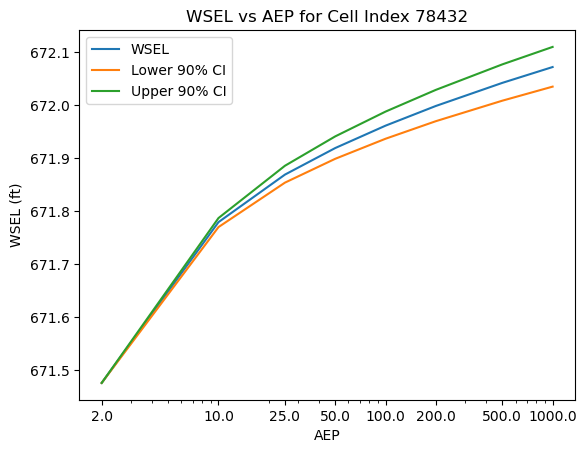

In [9]:
import random
plot_wsel_aep_curve(ds_result, random.randint(0, len(ds_result.index)))